# Ignition Delay Profiles for a Two-Stage Ignition Fuel

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Computing the ignition delay of a DME-air mixture for a range of temperatures and pressures

## Introduction

This demonstration shows how to use Spitfire to compute the ignition delay of a homogeneous mixture. Next, we vary the temperature and pressure to show the surprising ''negative temperature coefficient" (NTC) behavior in fuels that undergo two-stage ignition.

In [1]:
from spitfire import ChemicalMechanismSpec, HomogeneousReactor
import matplotlib.pyplot as plt

After some imports, we load up a dimethyl ether (DME) ignition mechanism and blend equal parts DME/methane with air to obtain a stoichiometric mixture.

In [4]:
mech = ChemicalMechanismSpec(cantera_input='dme-bhagatwala.yaml', group_name='dme-bhagatwala')

air = mech.stream(stp_air=True)
fuel = mech.stream('X', 'CH3OCH3:1, CH4:1')

blend = mech.mix_for_equivalence_ratio(1.0, fuel, air)

## Computing Ignition Delay

Next we specify the temperature and pressure of the mixture, put it into a constant-pressure reactor, and use `compute_ignition_delay()`.

In [5]:
from cantera import one_atm

blend.TP = 1200, 4 * one_atm

r = HomogeneousReactor(mech, blend, 'isobaric', 'adiabatic', 'closed')
tau = r.compute_ignition_delay()
print(f'Ignition delay for {blend.T:.1f} K, {blend.P / one_atm:.1f} atm is {tau*1e3:.2f} ms')

Ignition delay for 1200.0 K, 4.0 atm is 1.01 ms


## Plotting Ignition Delay over T, P

Now simply loop over temperature and pressure, resetting the blend temperature and pressure as we go. Note that we specify `first_time_step=1.e-9` for `compute_ignition_delay()`. This is important for time integrator stability for the largest pressures which ignite very early. The default initial time step of $10^{-6}\,{\rm s}$ is a bit too large there.

In [6]:
from numpy import linspace, zeros_like
from time import perf_counter as timer

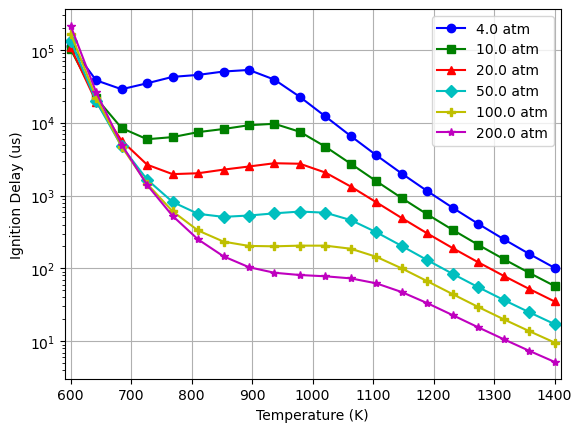

In [7]:
temperature_list = linspace(600., 1400., 20)
pressure_atm_list = [4., 10., 20., 50., 100., 200.]
tau_list = zeros_like(temperature_list)

colors_list  = ['b', 'g', 'r', 'c', 'y', 'm']
markers_list = ['o', 's', '^', 'D', 'P', '*']

fig = plt.figure()
ax  = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Ignition Delay (us)')
ax.set_xlim([temperature_list.min() - 10, temperature_list.max() + 10])
plt.ion()


for pressure, marker, color in zip(pressure_atm_list, markers_list, colors_list):
    for idx, temperature in enumerate(temperature_list):
        blend.TP = temperature, pressure * one_atm
        r = HomogeneousReactor(mech, blend, 'isobaric', 'adiabatic', 'closed')
        tau_list[idx] = r.compute_ignition_delay(first_time_step=1.e-9)
    ax.semilogy(temperature_list, tau_list * 1.e6, '-' + color + marker, label='{:.1f} atm'.format(pressure))

plt.legend()
plt.grid()
plt.show()

Fuels such as DME and biodiesel are of interest partially due to their low-temperature ignition pathways (advantageous for pollutant reduction) but their chemistry is extremely complex. A reasonable first expectation is that increasing temperature and pressure should always increase a mixture's overall reactivity, thus _decreasing_ its ignition delay. This is typically observed with most fuels (pressure is not trivial though - even hydrogen-air mixtures show nonmonotonic behavior with pressure variation - see CK Law's combustion text for an excellent description). However here we see increases in the ignition delay with temperature in a range of temperatures, which seems to be pressure-dependent. This is called "negative temperature coefficient" behavior and is due to degenerate chain branching in the low-temperature chemical pathways. It's a very complex subject, and being able to quickly simulate ignition behavior to match experimental data is a crucial aspect of our understanding.


## Conclusions

This notebook shows how to compute ignition delays of homogeneous mixtures. This is a common task in chemical mechanism development for combustion, and Spitfire makes it relatively painless.